### Training the network

$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$ Why it is using $\frac{1}{2}  ?$

During backpropagation, we are finding the optimal weights so things which are important is the weights -> We are optimizing for the weights always.

Note : Raw output is usally _logits_ or _scores_. Things with probabilities is that softmax gives you probabilities $\approx 0$ and floating point numbers cannot represent them well -> Hence we use the log-probabilities.


In [1]:
%matplotlib inline
import torch
from torch import nn
from torchvision import datasets, transforms
import random
from torch import optim
import matplotlib.pyplot as plt
import numpy as np



# Define a transform to normalize the data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ],
)

# download and load the training data
trainset_mnist = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=True, transform=transform)
testset_mnist = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=False, transform=transform)

trainset_fashion = datasets.FashionMNIST("~/.pytorch/MNIST_data/", download=True, train=True, transform=transform)
testset_fashion = datasets.FashionMNIST("~/.pytorch/MNIST_data/", download=True, train=False, transform=transform)

# configure the loaders
trainloader = torch.utils.data.DataLoader(trainset_mnist, batch_size=64, shuffle=True)
trainloader_fashion = torch.utils.data.DataLoader(trainset_fashion, batch_size=64, shuffle=True)

testloader = torch.utils.data.DataLoader(testset_mnist, batch_size=64, shuffle=True)
testloader_fashion = torch.utils.data.DataLoader(testset_fashion, batch_size=64, shuffle=True)


In [2]:
model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim = 1)
)
criterion = nn.CrossEntropyLoss()

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.shape[0], -1) # Flatten the image
logits = model(images)
loss = criterion(logits, labels)


print(f"Loss is {loss:.2f}")

Loss is 2.30


Because of stability issues using `nn.Softmax()` with `nn.CrossEntropyLoss()` is not good but we can use `nn.LogSoftmax()` and get the probabililties using `torch.exp()` and use `nn.NLLLoss()` -> Negative Likelihood Loss

the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1.


#### Autograd

Works by keeping track of all our operations -> set `requires_grad = True` to have autograd track it or have `torch.no_grad()`

Note : We are calculating how the loss function changes if the weights are changed.

In [3]:
random.seed(0)

x = torch.randn(2,2, requires_grad = True)
y = x ** 2
# y.backward() -> Grads can only be created for scalar outputs
z = y.mean()

z.backward()

x.grad, 2*x/torch.numel(x)


(tensor([[ 0.0354, -0.0783],
         [-0.3405, -0.3993]]),
 tensor([[ 0.0354, -0.0783],
         [-0.3405, -0.3993]], grad_fn=<DivBackward0>))

In [4]:
# Getting the model trained
print(f"Before {model[0].weight}")
loss.backward()
print(f"After {model[0].weight.grad}")

Before Parameter containing:
tensor([[-0.0277, -0.0162, -0.0100,  ...,  0.0177,  0.0286,  0.0096],
        [-0.0119,  0.0168,  0.0105,  ...,  0.0058, -0.0206, -0.0297],
        [ 0.0346, -0.0191, -0.0141,  ..., -0.0092,  0.0320, -0.0159],
        ...,
        [-0.0315,  0.0019, -0.0236,  ...,  0.0023, -0.0317, -0.0051],
        [ 0.0062, -0.0291, -0.0148,  ..., -0.0201, -0.0194,  0.0084],
        [ 0.0107, -0.0108, -0.0282,  ...,  0.0102,  0.0078, -0.0246]],
       requires_grad=True)
After tensor([[ 4.6899e-06,  4.6899e-06,  4.6899e-06,  ...,  4.6899e-06,
          4.6899e-06,  4.6899e-06],
        [-2.7028e-06, -2.7028e-06, -2.7028e-06,  ..., -2.7028e-06,
         -2.7028e-06, -2.7028e-06],
        [-1.0561e-04, -1.0561e-04, -1.0561e-04,  ..., -1.0561e-04,
         -1.0561e-04, -1.0561e-04],
        ...,
        [-1.0025e-04, -1.0025e-04, -1.0025e-04,  ..., -1.0025e-04,
         -1.0025e-04, -1.0025e-04],
        [-2.4153e-04, -2.4153e-04, -2.4153e-04,  ..., -2.4153e-04,
         -2.

In [5]:
optimizer = optim.SGD(model.parameters(), lr = 0.01)


Putting it all together : 

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

`optimizer.zero_grad()` sets the gradient to 0 or else what you can do is use `model.weights.grad.zero` to set them specifically


In [6]:
model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim = 1)
)


criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)

epochs = 5

for _ in range(epochs) :
    running_loss = 0
    for images, labels in trainloader_fashion : 
        optimizer.zero_grad() # Crucial step if you don't want to accumulate gradient
        
        images = images.view(images.shape[0], -1)
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Training loss: {loss.item():.2f}")     
    

Training loss: 0.58
Training loss: 0.35
Training loss: 0.41
Training loss: 0.37
Training loss: 0.19


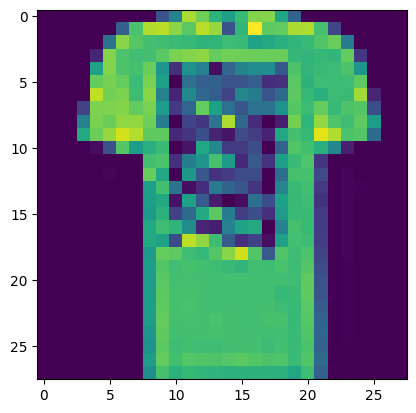

0

In [7]:
# predictions

dataiter = iter(trainloader_fashion)
images, labels = next(dataiter)

img = images[0]
img_noi = img.view(1,784)

probs = torch.exp(model(img_noi))
    
plt.imshow(img.squeeze(0))
plt.show()
np.argmax(probs.detach().numpy()) # some problem with the network, probabilities are not changing fairly constant.



Pretty good network

#### Inference & Validation

Post training you can use the network for predictions $\approx$ inference

Typically you would see a handout set -> Validation set where the inferencing would happen.

Metrics we are going to track 
* Accuracy 
* Precision : Rate of False positives
* Recall : Rate of False negatives

In [8]:
from torch import nn, optim
from torch.nn.functional import log_softmax, relu


class Classifier(nn.Module):
    """Classifier network with dropout."""

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # p = 0.2 is the probability
        self.dropout = nn.Dropout(p = 0.2 )

    def forward(self, x):
        """Forward pass through the network, returns the output logits."""
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        x = relu(self.fc1(x))
        x = self.dropout(relu(self.fc2(x)))
        x = relu(self.fc3(x))
        return log_softmax(self.fc4(x), dim=1)

In [9]:
model = Classifier()
criterion = nn.NLLLoss() # due to this there would be a problem using torch.exp() for loss calculation
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    running_test_loss = 0
    correct = 0
    total = 0
    for images, labels in trainloader: # training per batch
        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss/len(trainloader))

    with torch.no_grad():
        for images, labels in testloader : # testing on everything
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            running_test_loss += loss.item()
            
            # accuracy calculation
            top_p, top_class = torch.exp(log_ps).topk(1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            correct += equals.sum().item()
            total += labels.shape[0]
    
    accuracy = correct / total # per epoch calculation
    test_losses.append(running_test_loss/len(testloader))
    print(f"Validation Accuracy in {e} epoch is {accuracy:.2f} ")
        
            

Validation Accuracy in 0 epoch is 0.94 
Validation Accuracy in 1 epoch is 0.95 
Validation Accuracy in 2 epoch is 0.95 
Validation Accuracy in 3 epoch is 0.95 
Validation Accuracy in 4 epoch is 0.96 
Validation Accuracy in 5 epoch is 0.95 
Validation Accuracy in 6 epoch is 0.96 
Validation Accuracy in 7 epoch is 0.96 
Validation Accuracy in 8 epoch is 0.96 
Validation Accuracy in 9 epoch is 0.96 
Validation Accuracy in 10 epoch is 0.96 
Validation Accuracy in 11 epoch is 0.96 
Validation Accuracy in 12 epoch is 0.97 
Validation Accuracy in 13 epoch is 0.96 
Validation Accuracy in 14 epoch is 0.96 
Validation Accuracy in 15 epoch is 0.96 
Validation Accuracy in 16 epoch is 0.97 
Validation Accuracy in 17 epoch is 0.96 
Validation Accuracy in 18 epoch is 0.97 
Validation Accuracy in 19 epoch is 0.97 
Validation Accuracy in 20 epoch is 0.96 
Validation Accuracy in 21 epoch is 0.97 
Validation Accuracy in 22 epoch is 0.97 
Validation Accuracy in 23 epoch is 0.97 
Validation Accuracy in 24 

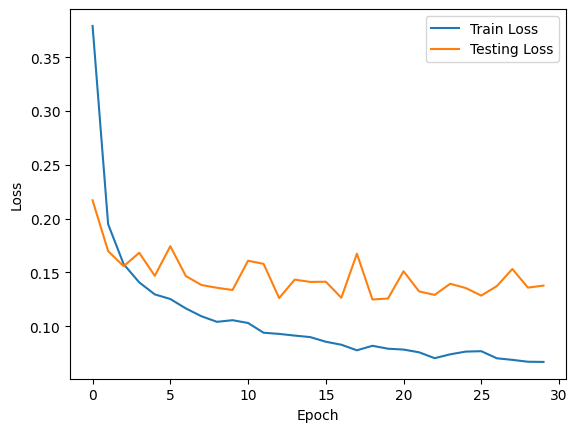

In [10]:
# plotting 
x = np.arange(epochs)
plt.plot(x, train_losses)
plt.plot(x, test_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Testing Loss"])
plt.show()

The training loss is decreasing while the testing loss is increasing -> this might result in overfitting. One way to reduce overfitting is to use `nn.Dropout()` and other is _early stopping_

In principle of early stopping you save the model weights per epoch and then choose the weights with the lowest loss.

`nn.Dropout()` randomly drops the input units

Caveat is that you need to use 
- `model.train()` : to use dropout during training
- `model.eval()` : to not use dropout during testing

In [11]:
class CoolClassifier(nn.Module) : 
    
    def __init__(self, lr = 0.03, epochs = 10) : 
        super().__init__()
        
        self.dropout = nn.Dropout(p = 0.2)
        
        # architecture
        self.model = nn.Sequential(
            nn.Linear(784, 256),
            self.dropout,
            nn.ReLU(),
            nn.Linear(256, 128),
            self.dropout,
            nn.ReLU(),
            nn.Linear(128, 64),
            self.dropout,
            nn.ReLU(),
            nn.Linear(64,10),
            nn.LogSoftmax(dim=1)  # Final activation, no ReLU or Dropout here
        )
        
        # configurations
        self.crit = nn.NLLLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr)
        self.epochs = epochs
        
        self.train_losses = []
        self.test_losses = []
        self.accuracy_ = []
        
        
    # def optimizer(self, lr) : 
    #     return optim.Adam(self.model.parameters(), lr)
    
    # def loss(self, output, inputs) : 
    #     return nn.NLLLoss(output, inputs)
        
    def forward(self, images) : 
        images = images.view(images.shape[0], -1)
        return self.model(images)
    
    def train_epoch(self, trainloader) : 
        
        """ One Epoch Training """
        self.model.train()
        
        running_loss = 0
        
        for images, labels in trainloader : 
            self.optimizer.zero_grad() # setting gradients to zero
            output = self.forward(images)
            loss = self.crit(output, labels)
            
            loss.backward()
            self.optimizer.step() # updating the parameters
            
            running_loss += loss.item() 
        
        avg_loss = running_loss / len(trainloader)
        self.train_losses.append(avg_loss)
        return avg_loss
        
    def validation(self, testloader) : 
        
        """ One Epoch Validation Testing """
        self.model.eval()
        
        running_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad() : 
            for images, labels in testloader : 
                output = self.forward(images)
                loss = self.crit(output, labels)
            
                running_loss += loss.item()
                correct += self.accuracy(output, labels)    
                total += labels.shape[0]
        
        avg_loss = running_loss / len(testloader)
        accuracy = correct/total
        self.test_losses.append(avg_loss)
        self.accuracy_.append(accuracy)
        return avg_loss, accuracy
    
    def accuracy(self, output, labels) : 
        _, predicted = torch.max(output, 1)
        correct = (predicted == labels).sum().item()
        return correct
        
    def train_model(self, testloader, trainloader, verbose = True) : 
        
        for e in range(self.epochs) : 
            train_loss = self.train_epoch(trainloader)
            test_loss, accuracy = self.validation(testloader)
            
            if verbose : 
                print(f"Epoch {e + 1} of {self.epochs}")
                print(f"Training Loss : {train_loss}")
                print(f"Test Loss : {test_loss} ")
                print(f"Accuracy : {accuracy}") 
    
    def plot_results(self):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        
        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.test_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.accuracy_, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()         

Epoch 1 of 15
Training Loss : 1.3577176939909625
Test Loss : 0.783067660672324 
Accuracy : 0.6863333333333334
Epoch 2 of 15
Training Loss : 0.7509898023240885
Test Loss : 0.6576376053125366 
Accuracy : 0.7562166666666666
Epoch 3 of 15
Training Loss : 0.6546893833549159
Test Loss : 0.5977381457016666 
Accuracy : 0.7728833333333334
Epoch 4 of 15
Training Loss : 0.5993407681869094
Test Loss : 0.5081924078529323 
Accuracy : 0.80485
Epoch 5 of 15
Training Loss : 0.5570233595219387
Test Loss : 0.5778962444267801 
Accuracy : 0.7708333333333334
Epoch 6 of 15
Training Loss : 0.5288086844857331
Test Loss : 0.47996516395479377 
Accuracy : 0.8226
Epoch 7 of 15
Training Loss : 0.5011238220391
Test Loss : 0.7379203703738987 
Accuracy : 0.7332166666666666
Epoch 8 of 15
Training Loss : 0.4858014680397738
Test Loss : 0.7772674066171463 
Accuracy : 0.7456166666666667
Epoch 9 of 15
Training Loss : 0.470137739921831
Test Loss : 0.43669419589517977 
Accuracy : 0.8414166666666667
Epoch 10 of 15
Training Los

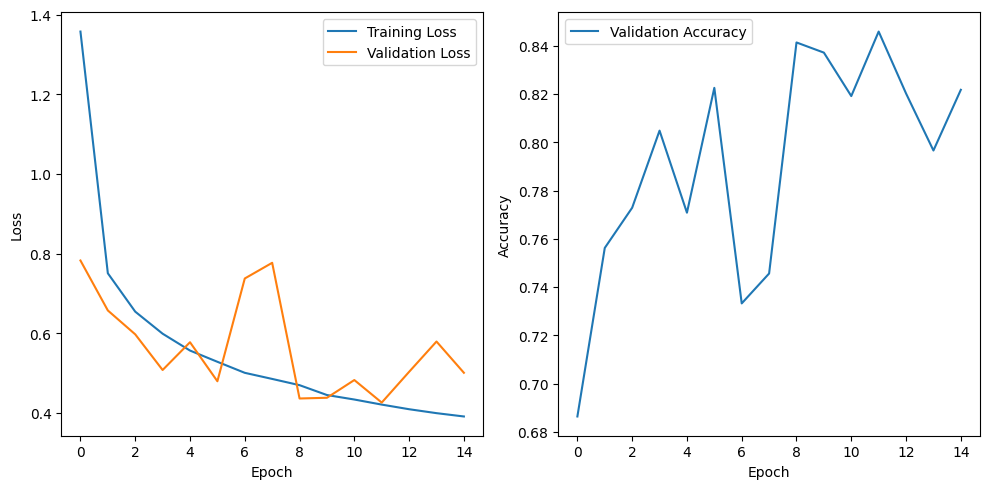

In [12]:
model = CoolClassifier(lr = 0.1, epochs= 15)
model.train_model(trainloader_fashion, testloader_fashion)
model.plot_results()

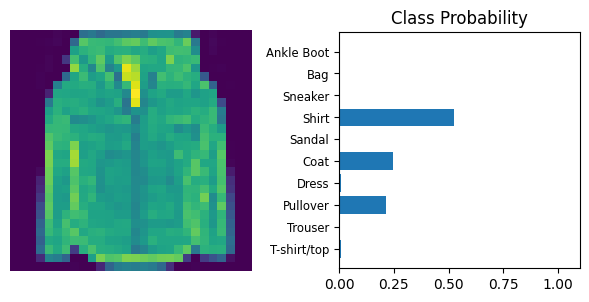

In [18]:
# Import helper module (should be in the repo)
import helper

model.eval()

dataiter = iter(testloader_fashion)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version="Fashion")

### Saving and loading networks

In [22]:
model.model.state_dict().keys() # gets you the weights and biases of the model

odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])

In [25]:
# saving the model
torch.save(model.model.state_dict(), "model.pth")

# loading the model
state_dict = torch.load("model.pth")
state_dict.keys()

odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])

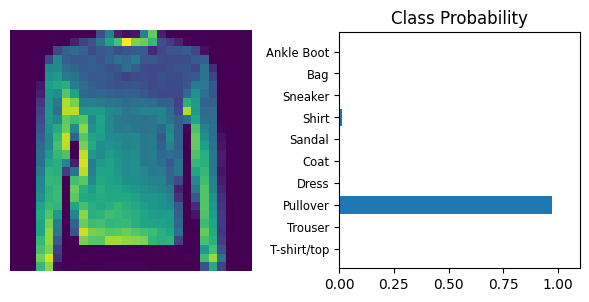

In [46]:
# adding to my network
model_noi = CoolClassifier(
    lr = 0.1,
    epochs = 15
)

model_noi.model.load_state_dict(state_dict)

# predictions - doing really well
dataiter = iter(testloader_fashion)
images, labels = next(dataiter)
img = images[0]
img_noi = img.view(1,784)
probs = torch.exp(model_noi.forward(img_noi))
helper.view_classify(img.view(1, 28, 28), probs, version="Fashion")


In [57]:
# problems comes when we don't have the right tensor size

checkpoint = {
    "input_size" : 784,
    "output_size" : 10,
    "hidden_layers" : [256, 128, 64],
    "dropout" : 0.2,
    "state_dict" : model_noi.model.state_dict(),
    "optimizer_dict" : model_noi.optimizer.state_dict(), # gives you the optimizer settings
}

torch.save(checkpoint, "checkpoint.pth")

### Key functions
- `torch.save()` : to save the model checkpoint
- `torch.load()` : to load the model checkpoint, always better to have more configuration
- `nn.Sequential().state_dict()` : to get the weights and biases
- `nn.Sequential().load_state_dict()` : to load the weights and biases